In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import seaborn as sns


In [27]:
features = pd.read_pickle("aug_features.pkl")
labels = pd.read_pickle("aug_labels.pkl")
#labels = pd.read_csv("../aug_labels.csv",index_col="challenge_oid")
features.index.name = "challenge_oid"
features_original = features.join(labels)
features_original = features_original[~pd.isna(features_original["classALeRCE"])]
features_test = pd.read_pickle("../test_features.pkl")

#features_wise = pd.read_csv("../WISE_data_4_hackathon_with_IDs.csv")
#join wise with train
#features_original = features_original.join(features_wise)#, on="challenge_oid")
#features_test = features_test.join(features_wise)#, on="challenge_oid")
#join wise with test

In [28]:
dropped_objects = features_original[features_original["classALeRCE"].isin(["EB", "LPV","QSO", "RRL"])].sample(frac=0.90)
features = features_original.drop(dropped_objects.index)
#features = features_original

In [29]:
#clustering_features_train = pd.read_csv("clustering_features_train.csv")
#clustering_features_test = pd.read_csv("clustering_features_test.csv")
#features = features.join(clustering_features_test.set_index("challenge_oid"))
#features_test = features_test.join(clustering_features_test.set_index("challenge_oid"))

In [30]:
#https://github.com/jrzaurin/LightGBM-with-Focal-Loss
import scipy
import scipy.misc
def focal_loss_lgb(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    # N observations x num_class arrays
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1,num_class, order='F')
    # alpha and gamma multiplicative factors with BCEWithLogitsLoss
    def fl(x,t):
        p = 1/(1+np.exp(-x))
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) )
    partial_fl = lambda x: fl(x, y_true)
    grad = scipy.misc.derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = scipy.misc.derivative(partial_fl, y_pred, n=2, dx=1e-6)
    # flatten in column-major (Fortran-style) order
    return grad.flatten('F'), hess.flatten('F')

def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma, num_class):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    num_class: int
        number of classes
    """
    a,g = alpha, gamma
    y_true = dtrain.label
    y_true = np.eye(num_class)[y_true.astype('int')]
    y_pred = y_pred.reshape(-1, num_class, order='F')
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    # a variant can be np.sum(loss)/num_class
    return 'focal_loss', np.mean(loss), False

In [31]:
import sklearn.preprocessing
import sklearn.model_selection
#import imblearn
#import imblearn.combine
#import imblearn.ensemble


#sampling = imblearn.combine.SMOTEENN(sampling_strategy={"EB" : 1000,"LPV": 1000,"QSO": 1000,"RRL": 1000,"SNII": 150,"SNIbc": 100,"Ceph" : 300,})
#error with NaN in data!
#import sklearn.impute
#test_data = sklearn.impute.SimpleImputer("median").fit_transform(features.drop("classALeRCE", axis=1))
#x_data, y_data = sampling.fit_resample(test_data, features["classALeRCE"])

label_encoder = sklearn.preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(features["classALeRCE"])


X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features.drop("classALeRCE", axis=1),
                                                                            encoded_labels, stratify=encoded_labels,
                                                                            test_size=0.2, random_state=0)
train_dataset = lgb.Dataset(X_train, 
                            label=y_train,
                            free_raw_data=True
                           )

test_dataset = lgb.Dataset(X_test, 
                            label=y_test,
                            free_raw_data=True
                           )

In [34]:
params = {
    'num_leaves' : 30,
    #'min_data_in_leaf' : 200,
    #'max_depth' : 30,
    'max_bin' : 60,
    'objective' : 'multiclass',
    'num_class' :14,
    'num_iterations' : 300,
    'learning_rate' : 0.05,
    'early_stopping_round' : 10,
    'num_threads' : 4,
    #'feature_fraction' : 0.75,
    #'bagging_fraction' : 0.75,
    #'bagging_freq' : 10,
    #'boosting' : 'dart',
}

In [35]:
focal_loss = lambda x,y: focal_loss_lgb(x, y, 0.25, 2, 14)
eval_error = lambda x,y: focal_loss_lgb_eval_error(x, y, 0.25, 2, 14)
model = lgb.train(params, train_dataset, valid_sets=[test_dataset], 
                  fobj=focal_loss,
                  feval=eval_error 
                 )

[1]	valid_0's focal_loss: 0.116418
Training until validation scores don't improve for 10 rounds
[2]	valid_0's focal_loss: 0.109578
[3]	valid_0's focal_loss: 0.103224
[4]	valid_0's focal_loss: 0.0973007
[5]	valid_0's focal_loss: 0.0917829
[6]	valid_0's focal_loss: 0.0866415
[7]	valid_0's focal_loss: 0.0818315
[8]	valid_0's focal_loss: 0.0773401
[9]	valid_0's focal_loss: 0.0731487
[10]	valid_0's focal_loss: 0.0692377
[11]	valid_0's focal_loss: 0.0655655
[12]	valid_0's focal_loss: 0.0621323
[13]	valid_0's focal_loss: 0.0589152
[14]	valid_0's focal_loss: 0.0559007
[15]	valid_0's focal_loss: 0.053073
[16]	valid_0's focal_loss: 0.0504142
[17]	valid_0's focal_loss: 0.0479194
[18]	valid_0's focal_loss: 0.0455906
[19]	valid_0's focal_loss: 0.0433912
[20]	valid_0's focal_loss: 0.0413271
[21]	valid_0's focal_loss: 0.0393822
[22]	valid_0's focal_loss: 0.0375513
[23]	valid_0's focal_loss: 0.0358367
[24]	valid_0's focal_loss: 0.0342205
[25]	valid_0's focal_loss: 0.0326854
[26]	valid_0's focal_loss: 

In [36]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / (np.sum(exp_x, axis=1, keepdims=True) + 1e-6)

prediction_no_softmax = model.predict(features_test)
prediction = softmax(prediction_no_softmax)


In [37]:
test_df = pd.DataFrame(prediction, columns=label_encoder.classes_)
test_df["challenge_oid"] = features_test.index
test_df = test_df.set_index("challenge_oid")
test_df["Outlier"] = 0.

In [38]:
outlier_scores = pd.read_csv("outliers_new.csv", index_col="challenge_oid")

In [39]:
test_df["Outlier"] = outlier_scores

In [40]:
#test_df = outlier_scores.join(test_df)
#renormalize probabilities
test_df_outliers = (test_df/test_df.sum(axis=1).values.reshape(-1, 1)).reset_index()

In [41]:
#test_df_outliers = pd.DataFrame(softmax(test_df.values), columns=test_df.columns)#, index=test_df.index)
#test_df_outliers["challenge_oid"] = test_df.index
test_df_outliers.to_csv("gb_if.csv", index=False)

In [42]:
test_df_outliers

,challenge_oid,AGN,Blazar,CV/Nova,Ceph,DSCT,EB,LPV,Periodic-Other,QSO,RRL,SNII,SNIa,SNIbc,YSO,Outlier
0,1282,0.032101,0.027323,0.036391,0.023834,0.044712,0.041008,0.020994,0.022389,0.040497,0.152873,0.038095,0.074652,0.091765,0.017769,0.335598
1,2086,0.056469,0.030416,0.055577,0.060364,0.021832,0.063968,0.023457,0.024321,0.048006,0.048741,0.032343,0.091171,0.088916,0.018613,0.335805
2,2508,0.045101,0.049866,0.057227,0.043047,0.034067,0.037696,0.021398,0.024621,0.041373,0.050881,0.036786,0.175738,0.047265,0.015130,0.319804
3,2799,0.030439,0.038368,0.042680,0.063061,0.051070,0.033527,0.027036,0.033942,0.033284,0.107332,0.079556,0.069040,0.056610,0.024735,0.309319
4,2934,0.063834,0.032359,0.052594,0.068952,0.038591,0.027213,0.031989,0.020453,0.053823,0.036588,0.039116,0.155366,0.026125,0.015986,0.337010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78076,644915,0.017620,0.021335,0.032194,0.016813,0.049346,0.036552,0.330409,0.012309,0.024370,0.025657,0.022855,0.058893,0.009667,0.023179,0.318801
78077,655425,0.085839,0.029361,0.032328,0.039555,0.027851,0.047524,0.021261,0.023841,0.045564,0.031416,0.049218,0.181013,0.046226,0.023390,0.315613
78078,659568,0.076426,0.033081,0.066910,0.072907,0.040368,0.070963,0.025878,0.038018,0.032941,0.048461,0.043028,0.068611,0.041117,0.024948,0.316343
78079,672755,0.034645,0.033565,0.054203,0.053622,0.044823,0.084356,0.032907,0.034739,0.043381,0.041071,0.045320,0.129390,0.034042,0.017532,0.316406


In [43]:
#CODE FROM https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14, normalize=True):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    fmt = '.2f' if normalize else 'd'
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [44]:
import sklearn.metrics
df_predict = softmax(model.predict(X_test))
cm = sklearn.metrics.confusion_matrix(y_test, 
                                      np.argmax(df_predict, axis=1),
                                      )

Normalized confusion matrix


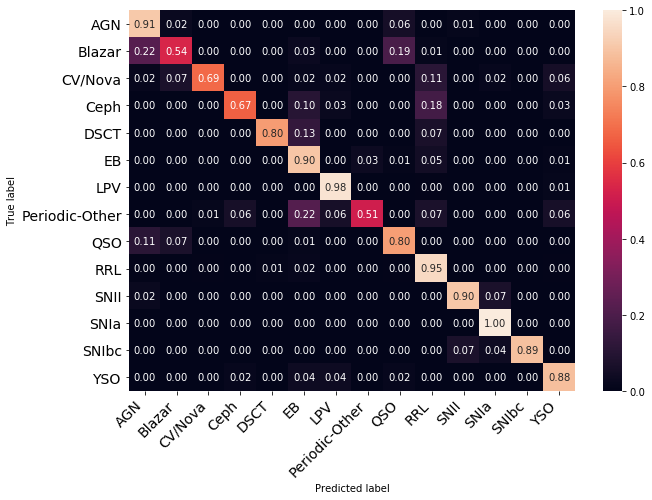

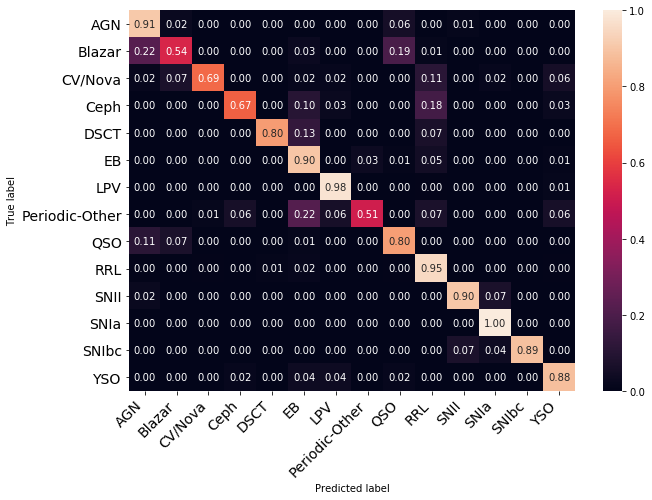

In [45]:
print_confusion_matrix(cm, label_encoder.classes_)

<BarContainer object of 14 artists>

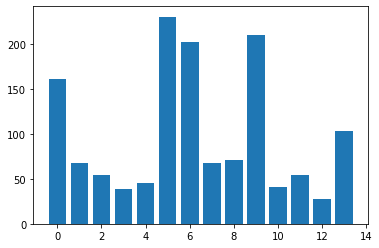

In [46]:
plt.bar(*np.unique(y_test, return_counts=True))

In [47]:
#todo try oversampling/undersampling with smote